In [19]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint

In [21]:
import splitfolders

input_folder = "processed_images/train" #Enter Input Folder
output = "processed_images/splitted_dataset" #Enter Output Folder

# This library split folders with files (e.g. images) into train, validation and test (dataset) folders.
# Ссылка на документацию по использованию: https://pypi.org/project/split-folders/
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 610 files [00:00, 3896.35 files/s]


In [22]:
batch_size = 32  # размер мини-пакета
img_height = 224 # высота изображения
img_width = 224  # длина изображения

# Создание обучающего набора данных:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory='processed_images/splitted_dataset/train', # путь к папке с обучающими данными
  label_mode = 'int',       # представление правильных ответов картинок в виде чисел (Label Encoding): 0, 1, 2, 3... (Также можно использовать One-Hot Encoding, для этого напишите categorical) (Если у вас задача бинарной классификации пишите binary)
  color_mode='rgb',         # представление каждой картинки в RGB формате
  batch_size=batch_size,    # параметр, с помощью которого можно регулировать порцию подаваемых примеров (картинок) для сети за одну итерацию обучения
  seed=123,                 # фиксированный seed для случайных процессов (например, перетасовки)
  image_size=(img_height, img_width), # нейронная сеть всегда принимает изображение определённого размера. Поэтому необходимо предварительно поменять размер каждого изображения
  shuffle=True)                       # перетасовка данных, чтобы генерировать данные не в определённом порядке (сначала 1 класс, потом 2 класс), а случайным образом

# Создание валидационного набора данных:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory='processed_images/splitted_dataset/val',  # путь к папке с валидационный данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False) # Отключаем shuffle (перемешивание), чтобы сохранить порядок данных и избежать внесения случайных изменений в процесс оценки модели.

# Создание тестового набора данных:
test_ds = tf.keras.utils.image_dataset_from_directory(
  directory='processed_images/splitted_dataset/test',  # путь к папке с тестовыми данными
  label_mode = 'int',
  color_mode='rgb',
  batch_size=batch_size,
  seed=123,
  image_size=(img_height, img_width),
  shuffle=False)

Found 487 files belonging to 2 classes.
Found 60 files belonging to 2 classes.
Found 63 files belonging to 2 classes.


In [23]:
class_names = train_ds.class_names # список классов
num_classes = len(class_names) # количество классов, чтобы указать их в последнем выходном слое
print(class_names)
print(num_classes)

['cataract', 'normal']
2


2024-10-27 01:10:17.568024: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:10:17.568062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:10:17.570293: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:10:17.570511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:10:17.572389: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:10:17.580481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:10:17.807233: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


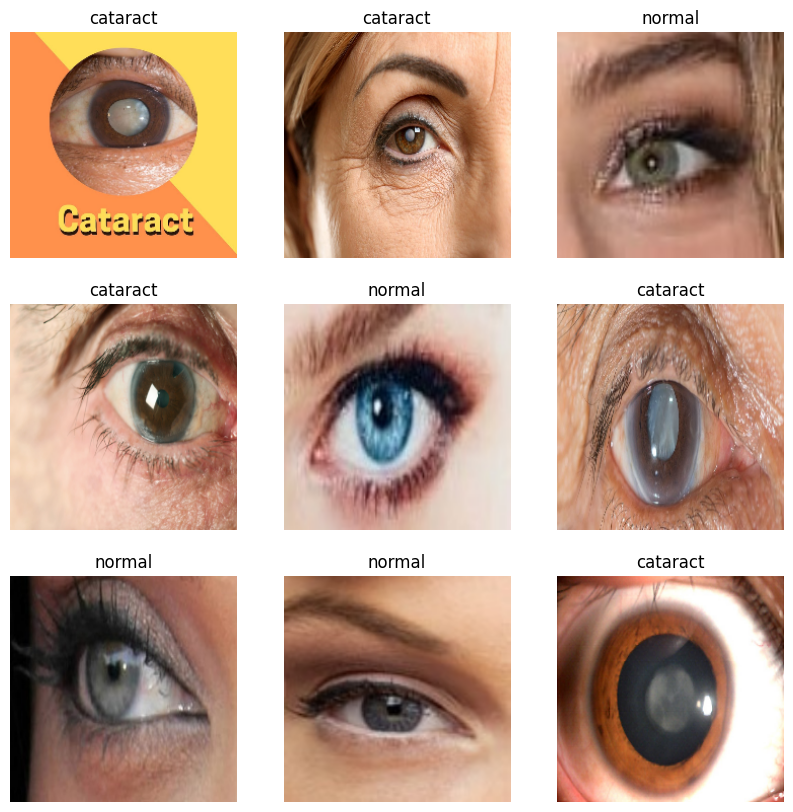

In [24]:
import matplotlib.pyplot as plt

# Визуализация примеров из тренировочного набора данных

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
def createModel(input_shape):
  # Входной слой
  input_layer = Input(shape=input_shape)

  # Нормализация данных от 0 до 1
  normalized_layer = Rescaling(1./255)(input_layer)

  # 1 блок свёртки (Conv + ReLU + MaxPool)
  conv_1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same') (normalized_layer)
  pool_1 = MaxPooling2D(2, 2) (conv_1)

  # 2 блок свёртки (Conv + ReLU + MaxPool)
  conv_2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same') (pool_1)
  pool_2 = MaxPooling2D(2, 2) (conv_2)

  # 3 блок свёртки (Conv + ReLU + MaxPool)
  conv_3 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same') (pool_2)
  pool_3 = MaxPooling2D(2, 2) (conv_3)

  # 4 блок свёртки (Conv + ReLU + MaxPool)
  conv_4 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same') (pool_3)
  pool_4 = MaxPooling2D(2, 2) (conv_4)

  # Классификационный слой
  averaged_features = GlobalAveragePooling2D() (pool_4) # усредняет каждый канал выходных признаков, что помогает уменьшить количество параметров и предотвращает переобучение.
  # Полносвязный слой для классификации с функцией активации софтмакс для получения вероятностей классов
  output = Dense(num_classes, activation='softmax') (averaged_features)

  return Model(inputs=input_layer, outputs=output)

In [26]:
def trainModel(train_dataset, val_dataset):
  # Сохранение только наилучшей модели с наименьшей ошибкой на валидации
  save_callback = ModelCheckpoint(filepath='best_model.weights.h5', # путь и название файла лучшей модели.
                                  monitor = 'val_loss',             # отслеживать каждую эпоху показать val_loss
                                  save_best_only = True,            # сохранять только самую лучшую модель
                                  save_weights_only=True,           # сохранять только веса модели (не всю модель);
                                  mode = 'min',                     # режим оптимизации min (найти минимальную ошибку)
                                  verbose=1)                        # 1 означает выводить информацию о нахождении и сохранении лучшей модели в процессе обучения, 0 означает не выводить.

  model = createModel((img_height, img_width, 3))                   # создание нашей свёрточной нейронной сети (размерность входа равна (img_height, img_width, 3))

  # Компиляция модели
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # алгоритм градиентного спуска, минимизирующий функцию ошибки. В нём можно задать скорость обучения (по умолчанию 0.001)
                loss='sparse_categorical_crossentropy',                  # функция ошибки sparse_categorical_crossentropy (поскольку метки представлены целыми числами int) категориальная кроссэнтропия для задачи многоклассовой классификации.
                metrics=['sparse_categorical_accuracy'])                 # метрика accuracy - точность.

  model.summary() # вывод информации о созданной модели

  model.fit(train_dataset,               # указываем обучающий набор данных
            validation_data=val_dataset,
            epochs=30,                   # количество эпох обучения. эпоха представляет собой один полный проход через все данные обучающего набора.
            callbacks=[save_callback]    # используем в процессе обучения созданный ModelCheckpoint
            )
  return model

In [27]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [29]:
model = trainModel(train_ds, val_ds)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,930 (1.48 MB)

 Trainable params: 388,930 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


2024-10-27 01:11:14.645628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:14.645765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:14.645864: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:14.648011: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:14.654930: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:14.674346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:14.720210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:14.728539: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:14.732083: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.6918 - sparse_categorical_accuracy: 0.5000

2024-10-27 01:11:15.061326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:15.075722: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:15.077137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.6924 - sparse_categorical_accuracy: 0.4844

2024-10-27 01:11:15.356112: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 296ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.4896

2024-10-27 01:11:15.668032: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.6994 - sparse_categorical_accuracy: 0.4844

2024-10-27 01:11:15.934161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:15.947863: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.7030 - sparse_categorical_accuracy: 0.4800

2024-10-27 01:11:16.223666: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:16.223845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:16.225276: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.7046 - sparse_categorical_accuracy: 0.4781

2024-10-27 01:11:16.504714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.7054 - sparse_categorical_accuracy: 0.4781

2024-10-27 01:11:16.766270: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:16.774640: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.7057 - sparse_categorical_accuracy: 0.4789

2024-10-27 01:11:17.043177: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/16 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.7056 - sparse_categorical_accuracy: 0.4830

2024-10-27 01:11:17.602823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:17.626357: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:17.628524: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/16 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.7054 - sparse_categorical_accuracy: 0.4851

2024-10-27 01:11:17.896741: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.7042 - sparse_categorical_accuracy: 0.4897

2024-10-27 01:11:19.101187: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:19.132698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:19.136771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 1: val_loss improved from inf to 0.69113, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - loss: 0.7041 - sparse_categorical_accuracy: 0.4898 - val_loss: 0.6911 - val_sparse_categorical_accuracy: 0.5167
Epoch 2/30


2024-10-27 01:11:19.520642: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:19.525633: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:19.545666: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:19.552674: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:19.553886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:19.592541: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.5938

2024-10-27 01:11:19.842882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.5781

2024-10-27 01:11:20.121357: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:20.122363: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:20.126554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:20.128981: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.6887 - sparse_categorical_accuracy: 0.5586

2024-10-27 01:11:20.684695: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:20.688998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:20.704503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:20.710977: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.6892 - sparse_categorical_accuracy: 0.5519

2024-10-27 01:11:20.968710: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:20.970693: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:20.983573: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.6897 - sparse_categorical_accuracy: 0.5450

2024-10-27 01:11:21.268908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.5379

2024-10-27 01:11:21.551881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:21.569546: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.6907 - sparse_categorical_accuracy: 0.5293

2024-10-27 01:11:21.865176: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:21.875776: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/16 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - loss: 0.6911 - sparse_categorical_accuracy: 0.5237

2024-10-27 01:11:22.146980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:22.147501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:22.150742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:22.169554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/16 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.5191

2024-10-27 01:11:22.442960: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:22.445251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:22.461832: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.6924 - sparse_categorical_accuracy: 0.5029

2024-10-27 01:11:23.865373: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:23.894871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:23.897848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 2: val_loss did not improve from 0.69113
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5012 - val_loss: 0.6925 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/30


2024-10-27 01:11:24.195296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.218150: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.218396: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.224308: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.251486: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.263091: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.263502: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.293580: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.302364: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 552ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.4688

2024-10-27 01:11:24.740777: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.748818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.757008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:24.797410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.4688

2024-10-27 01:11:25.049474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:25.060124: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.4722

2024-10-27 01:11:25.335402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:25.339451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.4733

2024-10-27 01:11:25.595404: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:25.595500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:25.597575: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:25.620242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.6927 - sparse_categorical_accuracy: 0.4822

2024-10-27 01:11:26.155614: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.6927 - sparse_categorical_accuracy: 0.4947

2024-10-27 01:11:28.562131: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:28.591552: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:28.595845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 3: val_loss improved from 0.69113 to 0.69006, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.6928 - sparse_categorical_accuracy: 0.4944 - val_loss: 0.6901 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/30


2024-10-27 01:11:28.923370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:28.956401: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:29.007749: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:29.040391: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:29.050013: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - loss: 0.6900 - sparse_categorical_accuracy: 0.5625

2024-10-27 01:11:29.301972: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:29.323523: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - loss: 0.6904 - sparse_categorical_accuracy: 0.5469

2024-10-27 01:11:29.590805: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:29.604174: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:29.608584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.6905 - sparse_categorical_accuracy: 0.5486

2024-10-27 01:11:29.896317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.6907 - sparse_categorical_accuracy: 0.5384

2024-10-27 01:11:30.157033: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:30.162938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.6911 - sparse_categorical_accuracy: 0.5246

2024-10-27 01:11:30.728945: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:30.736839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:30.760754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.6912 - sparse_categorical_accuracy: 0.5249

2024-10-27 01:11:31.012227: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.015531: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.020561: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.5276

2024-10-27 01:11:31.302056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.316202: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.328166: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/16 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.6913 - sparse_categorical_accuracy: 0.5284

2024-10-27 01:11:31.583506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.600777: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.617894: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/16 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.5271

2024-10-27 01:11:31.862305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.862669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.865789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.873236: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:31.890211: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.6916 - sparse_categorical_accuracy: 0.5237

2024-10-27 01:11:33.244341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.270059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.273837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 4: val_loss did not improve from 0.69006
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - loss: 0.6916 - sparse_categorical_accuracy: 0.5235 - val_loss: 0.6906 - val_sparse_categorical_accuracy: 0.5333
Epoch 5/30


2024-10-27 01:11:33.566701: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.575108: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.583620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.589284: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.600130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.645001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.701295: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.703762: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:33.708790: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 491ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.3750

2024-10-27 01:11:34.053442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.053648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.054297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.057313: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.085403: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - loss: 0.6920 - sparse_categorical_accuracy: 0.4453

2024-10-27 01:11:34.354392: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.357320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.4878

2024-10-27 01:11:34.635337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.642472: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.661521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.5046

2024-10-27 01:11:34.927196: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.941906: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.944198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:34.958799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.6904 - sparse_categorical_accuracy: 0.5223

2024-10-27 01:11:35.773829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.6898 - sparse_categorical_accuracy: 0.5230

2024-10-27 01:11:37.937708: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:37.967397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:37.972799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 5: val_loss improved from 0.69006 to 0.67293, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.6899 - sparse_categorical_accuracy: 0.5216 - val_loss: 0.6729 - val_sparse_categorical_accuracy: 0.5333
Epoch 6/30


2024-10-27 01:11:38.273735: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:38.290075: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:38.297274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:38.303452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:38.384831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:38.393559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:38.434757: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:38.436530: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:38.462259: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - loss: 0.6763 - sparse_categorical_accuracy: 0.5625

2024-10-27 01:11:39.142776: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - loss: 0.6779 - sparse_categorical_accuracy: 0.5764

2024-10-27 01:11:39.404738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:39.408540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:39.408995: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.6792 - sparse_categorical_accuracy: 0.5788

2024-10-27 01:11:39.683101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:39.692261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:39.692713: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.6796 - sparse_categorical_accuracy: 0.5805

2024-10-27 01:11:39.959266: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:39.971406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:39.976653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.6794 - sparse_categorical_accuracy: 0.5827

2024-10-27 01:11:40.239873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:40.248275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.6820 - sparse_categorical_accuracy: 0.5731

2024-10-27 01:11:42.668345: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:42.698037: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:42.702479: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 6: val_loss did not improve from 0.67293
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.6824 - sparse_categorical_accuracy: 0.5720 - val_loss: 0.6741 - val_sparse_categorical_accuracy: 0.5833
Epoch 7/30


2024-10-27 01:11:42.983710: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:42.985950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:42.986116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.043505: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.064596: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.072207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.074730: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.086457: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.105883: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 404ms/step - loss: 0.6850 - sparse_categorical_accuracy: 0.5625

2024-10-27 01:11:43.384659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.394569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.396860: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.406703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.411018: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - loss: 0.6783 - sparse_categorical_accuracy: 0.5938

2024-10-27 01:11:43.675288: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:43.688350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - loss: 0.6788 - sparse_categorical_accuracy: 0.5868

2024-10-27 01:11:43.991169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - loss: 0.6782 - sparse_categorical_accuracy: 0.5866

2024-10-27 01:11:44.288791: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:44.296110: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 0.6782 - sparse_categorical_accuracy: 0.5868

2024-10-27 01:11:44.584901: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:44.595150: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - loss: 0.6777 - sparse_categorical_accuracy: 0.5897

2024-10-27 01:11:44.843080: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:44.850313: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:44.854470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:44.857963: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.6774 - sparse_categorical_accuracy: 0.5922

2024-10-27 01:11:45.112959: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:45.120591: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:45.128663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/16 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.6786 - sparse_categorical_accuracy: 0.5869

2024-10-27 01:11:45.941406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.6812 - sparse_categorical_accuracy: 0.5707

2024-10-27 01:11:47.301868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.337383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.341639: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 7: val_loss did not improve from 0.67293
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 282ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.5691 - val_loss: 0.6750 - val_sparse_categorical_accuracy: 0.5333
Epoch 8/30


2024-10-27 01:11:47.629953: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.635257: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.667304: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.672434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.721400: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.748008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.767729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.769156: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:47.773277: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 613ms/step - loss: 0.6966 - sparse_categorical_accuracy: 0.6250

2024-10-27 01:11:48.062433: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:48.099379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:48.232135: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:48.245430: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:48.266285: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.6016

2024-10-27 01:11:48.515254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:48.517011: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:48.524725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - loss: 0.6906 - sparse_categorical_accuracy: 0.5885

2024-10-27 01:11:48.799969: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.6881 - sparse_categorical_accuracy: 0.5879

2024-10-27 01:11:49.082071: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:49.082596: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:49.082870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:49.090015: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:49.105880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.6861 - sparse_categorical_accuracy: 0.5841

2024-10-27 01:11:49.377750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:49.386473: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.6856 - sparse_categorical_accuracy: 0.5779

2024-10-27 01:11:49.656161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.6794 - sparse_categorical_accuracy: 0.5599

2024-10-27 01:11:52.064447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.094723: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.100370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 8: val_loss improved from 0.67293 to 0.64101, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - loss: 0.6789 - sparse_categorical_accuracy: 0.5591 - val_loss: 0.6410 - val_sparse_categorical_accuracy: 0.6000
Epoch 9/30


2024-10-27 01:11:52.422631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.438891: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.471522: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.475970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.480186: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.495246: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.525758: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.529272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.530507: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 552ms/step - loss: 0.6488 - sparse_categorical_accuracy: 0.5938

2024-10-27 01:11:52.966690: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.984158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:52.995951: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 0.6442 - sparse_categorical_accuracy: 0.6094

2024-10-27 01:11:53.265983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.6480 - sparse_categorical_accuracy: 0.6081

2024-10-27 01:11:53.843593: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:53.845591: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.6471 - sparse_categorical_accuracy: 0.6115

2024-10-27 01:11:54.125116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:54.131482: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:54.144550: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.6455 - sparse_categorical_accuracy: 0.6146

2024-10-27 01:11:54.396945: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:54.415538: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.6173

2024-10-27 01:11:54.683398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:54.703039: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.6578 - sparse_categorical_accuracy: 0.5920

2024-10-27 01:11:56.829546: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:56.860125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:56.862966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 9: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.6589 - sparse_categorical_accuracy: 0.5890 - val_loss: 0.6776 - val_sparse_categorical_accuracy: 0.5833
Epoch 10/30


2024-10-27 01:11:57.143273: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.144233: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.153400: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.163902: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.280782: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.296965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.298032: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.334970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.346099: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 590ms/step - loss: 0.6789 - sparse_categorical_accuracy: 0.6875

2024-10-27 01:11:57.595210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.597161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.735173: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.743323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.753058: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:57.782805: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - loss: 0.6815 - sparse_categorical_accuracy: 0.6484

2024-10-27 01:11:58.029976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:58.030491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:58.038232: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:58.049466: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - loss: 0.6813 - sparse_categorical_accuracy: 0.6372

2024-10-27 01:11:58.352470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.6813 - sparse_categorical_accuracy: 0.6283

2024-10-27 01:11:58.613412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:11:58.623334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - loss: 0.6809 - sparse_categorical_accuracy: 0.6251

2024-10-27 01:11:58.885093: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.6815 - sparse_categorical_accuracy: 0.5772

2024-10-27 01:12:01.537452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:01.567136: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:01.570645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 10: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.5750 - val_loss: 0.6669 - val_sparse_categorical_accuracy: 0.6000
Epoch 11/30


2024-10-27 01:12:01.856822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:01.866920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:01.873449: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:01.877188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:01.888985: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:01.971663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:01.978938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - loss: 0.6924 - sparse_categorical_accuracy: 0.6562

2024-10-27 01:12:02.251298: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.252637: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.264290: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.6919 - sparse_categorical_accuracy: 0.6328

2024-10-27 01:12:02.545830: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.546416: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.6888 - sparse_categorical_accuracy: 0.6094

2024-10-27 01:12:02.832477: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.833748: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.834214: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.842942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.848045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.858961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:02.862865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.6866 - sparse_categorical_accuracy: 0.5898

2024-10-27 01:12:03.132432: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - loss: 0.6851 - sparse_categorical_accuracy: 0.5744

2024-10-27 01:12:03.409898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:03.410752: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.6843 - sparse_categorical_accuracy: 0.5672

2024-10-27 01:12:03.698688: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.6836 - sparse_categorical_accuracy: 0.5614

2024-10-27 01:12:03.959502: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:03.960173: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:03.969542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:03.985270: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/16 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.6831 - sparse_categorical_accuracy: 0.5419

2024-10-27 01:12:04.802251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:04.809753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:04.827881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.6808 - sparse_categorical_accuracy: 0.5271

2024-10-27 01:12:06.177242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.204897: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.210996: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 11: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.6805 - sparse_categorical_accuracy: 0.5261 - val_loss: 0.6586 - val_sparse_categorical_accuracy: 0.5833
Epoch 12/30


2024-10-27 01:12:06.499318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.545092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.577407: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.594547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.594653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.596464: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.619373: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.624648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:06.659048: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 602ms/step - loss: 0.6714 - sparse_categorical_accuracy: 0.4375

2024-10-27 01:12:07.097592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:07.098633: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:07.101451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:07.113083: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:07.120837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:07.127826: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 0.6688 - sparse_categorical_accuracy: 0.5234

2024-10-27 01:12:07.397161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.5642

2024-10-27 01:12:07.684050: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:07.709264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.6641 - sparse_categorical_accuracy: 0.5833

2024-10-27 01:12:07.956584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:07.968397: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:07.972005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.6638 - sparse_categorical_accuracy: 0.5867

2024-10-27 01:12:08.258848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.6674 - sparse_categorical_accuracy: 0.5839

2024-10-27 01:12:10.905492: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:10.932314: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:10.937667: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 12: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.5836 - val_loss: 0.6482 - val_sparse_categorical_accuracy: 0.6000
Epoch 13/30


2024-10-27 01:12:11.244441: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:11.262675: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:11.265753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:11.295973: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:11.320750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:11.346870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:11.397889: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:11.434796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:11.439817: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.5859

2024-10-27 01:12:12.098961: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:12.111718: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - loss: 0.6527 - sparse_categorical_accuracy: 0.5747

2024-10-27 01:12:12.357676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.6587 - sparse_categorical_accuracy: 0.5638

2024-10-27 01:12:12.641104: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:12.652704: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:12.662920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.6622 - sparse_categorical_accuracy: 0.5573

2024-10-27 01:12:12.946842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.6646 - sparse_categorical_accuracy: 0.5538

2024-10-27 01:12:13.234904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:13.240103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.5519

2024-10-27 01:12:13.504285: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:13.515687: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:13.520014: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.6701 - sparse_categorical_accuracy: 0.5578

2024-10-27 01:12:15.675207: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:15.703073: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:15.709122: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 13: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.6702 - sparse_categorical_accuracy: 0.5586 - val_loss: 0.6589 - val_sparse_categorical_accuracy: 0.6000
Epoch 14/30


2024-10-27 01:12:16.010345: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.013317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.041086: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.056145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.060128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.095394: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.120450: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.151886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.155496: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 553ms/step - loss: 0.6558 - sparse_categorical_accuracy: 0.4375

2024-10-27 01:12:16.540842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.541020: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:16.551350: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.4766

2024-10-27 01:12:16.840836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.5017

2024-10-27 01:12:17.090632: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:17.102326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:17.104269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.5150

2024-10-27 01:12:17.366219: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - loss: 0.6658 - sparse_categorical_accuracy: 0.5257

2024-10-27 01:12:17.636329: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:17.641679: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:17.675500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.6649 - sparse_categorical_accuracy: 0.5362

2024-10-27 01:12:17.952577: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:17.957881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.6634 - sparse_categorical_accuracy: 0.5451

2024-10-27 01:12:18.225965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:18.233621: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.6624 - sparse_categorical_accuracy: 0.5511

2024-10-27 01:12:18.517222: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.6582 - sparse_categorical_accuracy: 0.5748

2024-10-27 01:12:20.419377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.452429: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.457895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 14: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.5764 - val_loss: 0.9412 - val_sparse_categorical_accuracy: 0.5667
Epoch 15/30


2024-10-27 01:12:20.751526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.771106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.779871: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.796487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.821334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.826431: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.841701: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.846500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:20.880236: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 637ms/step - loss: 0.8467 - sparse_categorical_accuracy: 0.4688

2024-10-27 01:12:21.378160: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.7841 - sparse_categorical_accuracy: 0.5391

2024-10-27 01:12:21.660638: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:21.662503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:21.663530: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:21.672277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.7504 - sparse_categorical_accuracy: 0.5677

2024-10-27 01:12:21.957537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:21.962376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:21.971964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.7333 - sparse_categorical_accuracy: 0.5781

2024-10-27 01:12:22.240548: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:22.244342: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.7256 - sparse_categorical_accuracy: 0.5788

2024-10-27 01:12:22.513707: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.7096 - sparse_categorical_accuracy: 0.5451

2024-10-27 01:12:25.238075: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.265645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.270455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 15: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.7090 - sparse_categorical_accuracy: 0.5444 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.5667
Epoch 16/30


2024-10-27 01:12:25.554672: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.562382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.568346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.601516: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.675386: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.681441: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.694637: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.715415: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:25.746232: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 521ms/step - loss: 0.6887 - sparse_categorical_accuracy: 0.5000

2024-10-27 01:12:26.068825: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:26.070572: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - loss: 0.6889 - sparse_categorical_accuracy: 0.5078

2024-10-27 01:12:26.358151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.5122

2024-10-27 01:12:26.648035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:26.651653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.6869 - sparse_categorical_accuracy: 0.5111

2024-10-27 01:12:26.919439: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:26.920727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:26.930823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:26.935451: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.6853 - sparse_categorical_accuracy: 0.5064

2024-10-27 01:12:27.203620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:27.204021: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:27.209244: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.6844 - sparse_categorical_accuracy: 0.5070

2024-10-27 01:12:27.480732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:27.481816: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:27.495837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.6833 - sparse_categorical_accuracy: 0.5092

2024-10-27 01:12:27.772038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.6827 - sparse_categorical_accuracy: 0.5120

2024-10-27 01:12:28.045208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:28.055161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:28.060778: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.6789 - sparse_categorical_accuracy: 0.5325

2024-10-27 01:12:29.958268: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:29.989432: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:29.995338: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 16: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - loss: 0.6788 - sparse_categorical_accuracy: 0.5336 - val_loss: 0.6649 - val_sparse_categorical_accuracy: 0.5667
Epoch 17/30


2024-10-27 01:12:30.283384: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.284105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.290260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.299656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.301305: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.347553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.440768: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.444706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.478988: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 638ms/step - loss: 0.6657 - sparse_categorical_accuracy: 0.4375

2024-10-27 01:12:30.918044: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.922027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:30.923861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.4922

2024-10-27 01:12:31.198190: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.6564 - sparse_categorical_accuracy: 0.4980

2024-10-27 01:12:31.753666: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - loss: 0.6578 - sparse_categorical_accuracy: 0.4997

2024-10-27 01:12:32.022315: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:32.033811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.4989

2024-10-27 01:12:32.284582: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:32.285733: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:32.289330: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:32.312526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - loss: 0.6628 - sparse_categorical_accuracy: 0.4984

2024-10-27 01:12:32.574552: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.6690 - sparse_categorical_accuracy: 0.5157

2024-10-27 01:12:34.778275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:34.807567: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:34.813814: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 17: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.6691 - sparse_categorical_accuracy: 0.5174 - val_loss: 0.6643 - val_sparse_categorical_accuracy: 0.5667
Epoch 18/30


2024-10-27 01:12:35.111283: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.127711: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.135227: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.177628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.188296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.196481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.196964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.208660: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.274405: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 544ms/step - loss: 0.6609 - sparse_categorical_accuracy: 0.5938

2024-10-27 01:12:35.645943: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.646556: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.653925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:35.655694: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.6646 - sparse_categorical_accuracy: 0.5486

2024-10-27 01:12:36.217125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:36.237601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.6660 - sparse_categorical_accuracy: 0.5443

2024-10-27 01:12:36.493010: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:36.506453: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:36.509413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.6653 - sparse_categorical_accuracy: 0.5519

2024-10-27 01:12:37.043909: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.5560

2024-10-27 01:12:37.337240: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:37.345221: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.6664 - sparse_categorical_accuracy: 0.5583

2024-10-27 01:12:37.600662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:37.612710: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.6667 - sparse_categorical_accuracy: 0.5685

2024-10-27 01:12:39.497590: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.529074: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.533104: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 18: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - loss: 0.6668 - sparse_categorical_accuracy: 0.5684 - val_loss: 0.6450 - val_sparse_categorical_accuracy: 0.5833
Epoch 19/30


2024-10-27 01:12:39.820885: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.824880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.831703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.834220: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.838458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.880245: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.881208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.898616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:39.940414: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 614ms/step - loss: 0.6990 - sparse_categorical_accuracy: 0.6250

2024-10-27 01:12:40.430798: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:40.434764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:40.455234: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - loss: 0.6724 - sparse_categorical_accuracy: 0.6719

2024-10-27 01:12:40.727877: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:40.739259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.6659 - sparse_categorical_accuracy: 0.6667

2024-10-27 01:12:41.015121: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:41.025087: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.6625 - sparse_categorical_accuracy: 0.6602

2024-10-27 01:12:41.284919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:41.293947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:41.300935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:41.308930: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.6572 - sparse_categorical_accuracy: 0.6519

2024-10-27 01:12:41.599980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.6559 - sparse_categorical_accuracy: 0.6439

2024-10-27 01:12:41.838714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.6582 - sparse_categorical_accuracy: 0.6045

2024-10-27 01:12:44.258859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.287911: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.291275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 19: val_loss did not improve from 0.64101
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - loss: 0.6584 - sparse_categorical_accuracy: 0.6034 - val_loss: 0.6600 - val_sparse_categorical_accuracy: 0.5833
Epoch 20/30


2024-10-27 01:12:44.574459: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.575923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.604270: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.672365: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.680295: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.694141: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.698643: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.727314: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:44.743915: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 8s 597ms/step - loss: 0.6875 - sparse_categorical_accuracy: 0.5000

2024-10-27 01:12:45.174395: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:45.191914: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 0.6755 - sparse_categorical_accuracy: 0.5434

2024-10-27 01:12:45.718732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.5462

2024-10-27 01:12:45.988993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:46.001369: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:46.007767: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.6681 - sparse_categorical_accuracy: 0.5420

2024-10-27 01:12:46.292743: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:46.302994: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.6665 - sparse_categorical_accuracy: 0.5411

2024-10-27 01:12:46.586954: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.5409

2024-10-27 01:12:46.853266: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:46.854171: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:46.854985: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.5514

2024-10-27 01:12:49.006611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.036476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.041364: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 20: val_loss improved from 0.64101 to 0.63535, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step - loss: 0.6626 - sparse_categorical_accuracy: 0.5519 - val_loss: 0.6353 - val_sparse_categorical_accuracy: 0.5833
Epoch 21/30


2024-10-27 01:12:49.416650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.433942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.453691: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.454573: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.455677: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.466379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.481853: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.492410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:49.497424: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 665ms/step - loss: 0.6537 - sparse_categorical_accuracy: 0.6562

2024-10-27 01:12:50.039102: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:50.043867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:50.057014: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 303ms/step - loss: 0.6729 - sparse_categorical_accuracy: 0.6094

2024-10-27 01:12:50.343558: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:50.358843: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:50.359409: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.6762 - sparse_categorical_accuracy: 0.5905

2024-10-27 01:12:50.922454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.6744 - sparse_categorical_accuracy: 0.5886

2024-10-27 01:12:51.186927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.6579 - sparse_categorical_accuracy: 0.6066

2024-10-27 01:12:53.861660: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:53.894947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:53.897069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 21: val_loss improved from 0.63535 to 0.61686, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - loss: 0.6572 - sparse_categorical_accuracy: 0.6069 - val_loss: 0.6169 - val_sparse_categorical_accuracy: 0.5833
Epoch 22/30


2024-10-27 01:12:54.521243: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:54.522837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:54.524394: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:54.558899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:54.591793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:54.594188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:54.623895: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:54.708907: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:54.731456: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 290ms/step - loss: 0.6446 - sparse_categorical_accuracy: 0.5859

2024-10-27 01:12:55.344274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:55.356698: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 281ms/step - loss: 0.6407 - sparse_categorical_accuracy: 0.5920

2024-10-27 01:12:55.618267: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - loss: 0.6429 - sparse_categorical_accuracy: 0.5885

2024-10-27 01:12:55.899488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:55.907503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:55.910605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.6416 - sparse_categorical_accuracy: 0.5908

2024-10-27 01:12:56.195103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:56.197334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:56.203744: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.6403 - sparse_categorical_accuracy: 0.5913

2024-10-27 01:12:56.485887: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:56.497176: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.6398 - sparse_categorical_accuracy: 0.5921

2024-10-27 01:12:57.035863: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:57.036675: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.6070

2024-10-27 01:12:58.912270: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:58.942311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:58.948254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 22: val_loss did not improve from 0.61686
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.6079 - val_loss: 0.6718 - val_sparse_categorical_accuracy: 0.6000
Epoch 23/30


2024-10-27 01:12:59.245184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:59.264337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:59.267171: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:59.273299: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:59.293873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:59.342688: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:59.356125: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - loss: 0.7506 - sparse_categorical_accuracy: 0.4375

2024-10-27 01:12:59.629481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:12:59.651620: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.7250 - sparse_categorical_accuracy: 0.4861

2024-10-27 01:13:00.202743: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:00.203654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.7146 - sparse_categorical_accuracy: 0.5033

2024-10-27 01:13:00.477035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:00.480926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:00.493137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:00.499874: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.7053 - sparse_categorical_accuracy: 0.5226

2024-10-27 01:13:00.758222: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:00.759809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:00.761216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:00.769618: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.6983 - sparse_categorical_accuracy: 0.5362

2024-10-27 01:13:01.039619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:01.045696: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:01.053038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:01.054616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.6927 - sparse_categorical_accuracy: 0.5476

2024-10-27 01:13:01.347977: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:01.351646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:01.371545: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:01.380352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.6892 - sparse_categorical_accuracy: 0.5539

2024-10-27 01:13:01.645346: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/16 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.6865 - sparse_categorical_accuracy: 0.5602

2024-10-27 01:13:01.908495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/16 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.6841 - sparse_categorical_accuracy: 0.5651

2024-10-27 01:13:02.180083: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 0.6705 - sparse_categorical_accuracy: 0.5806

2024-10-27 01:13:03.570167: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:03.598664: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:03.602598: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 23: val_loss improved from 0.61686 to 0.60889, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - loss: 0.6690 - sparse_categorical_accuracy: 0.5824 - val_loss: 0.6089 - val_sparse_categorical_accuracy: 0.6167
Epoch 24/30


2024-10-27 01:13:03.951438: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:03.990429: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.024291: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.030638: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.088886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.089343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.107746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.154408: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.198308: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 0.6178 - sparse_categorical_accuracy: 0.7344

2024-10-27 01:13:04.816259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.816983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.826349: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.835176: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.835569: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:04.843879: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.6232 - sparse_categorical_accuracy: 0.7049

2024-10-27 01:13:05.113149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.6908

2024-10-27 01:13:05.406848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.6826

2024-10-27 01:13:05.684440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:05.685513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:05.704669: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:05.708566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.6219 - sparse_categorical_accuracy: 0.6765

2024-10-27 01:13:05.971966: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:05.972227: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:05.972665: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:05.980001: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.6072 - sparse_categorical_accuracy: 0.6671

2024-10-27 01:13:08.378242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.405654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.410481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 24: val_loss did not improve from 0.60889
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - loss: 0.6075 - sparse_categorical_accuracy: 0.6659 - val_loss: 0.6165 - val_sparse_categorical_accuracy: 0.6167
Epoch 25/30


2024-10-27 01:13:08.731248: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.732501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.734332: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.736501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.749818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.774815: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.788383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.823597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:08.876493: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - loss: 0.6042 - sparse_categorical_accuracy: 0.5625

2024-10-27 01:13:09.089358: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:09.097251: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:09.119211: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - loss: 0.5990 - sparse_categorical_accuracy: 0.5983

2024-10-27 01:13:09.936185: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:09.949706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.6012 - sparse_categorical_accuracy: 0.5974

2024-10-27 01:13:10.239229: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:10.249319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.6065 - sparse_categorical_accuracy: 0.5968

2024-10-27 01:13:10.500283: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:10.503232: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - loss: 0.6112 - sparse_categorical_accuracy: 0.5932

2024-10-27 01:13:10.772623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:10.778763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:10.783590: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/16 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.6144 - sparse_categorical_accuracy: 0.5923

2024-10-27 01:13:11.067663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:11.072127: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/16 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.6169 - sparse_categorical_accuracy: 0.5917

2024-10-27 01:13:11.355120: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:11.366545: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:11.379520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/16 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.5934

2024-10-27 01:13:11.634395: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:11.656035: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/16 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.6201 - sparse_categorical_accuracy: 0.5945

2024-10-27 01:13:11.913803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.5973

2024-10-27 01:13:13.022236: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.054082: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.058646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 25: val_loss did not improve from 0.60889
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.6279 - sparse_categorical_accuracy: 0.5976 - val_loss: 0.6437 - val_sparse_categorical_accuracy: 0.6167
Epoch 26/30


2024-10-27 01:13:13.341771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.354758: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.413277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.420526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.453126: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.463798: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.500054: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.515539: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.553793: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - loss: 0.6549 - sparse_categorical_accuracy: 0.6875

2024-10-27 01:13:13.846383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.867521: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:13.873730: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 307ms/step - loss: 0.6344 - sparse_categorical_accuracy: 0.7031

2024-10-27 01:13:14.150217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.158105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.164790: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.167645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.175223: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 0.6267 - sparse_categorical_accuracy: 0.7118

2024-10-27 01:13:14.439742: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.447143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.451763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.460037: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.7135

2024-10-27 01:13:14.718716: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.719870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:14.745464: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.6235 - sparse_categorical_accuracy: 0.7046

2024-10-27 01:13:15.007589: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:15.008809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:15.030762: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.6242 - sparse_categorical_accuracy: 0.6965

2024-10-27 01:13:15.291284: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.6236 - sparse_categorical_accuracy: 0.6543

2024-10-27 01:13:17.715043: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:17.744734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:17.748106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 26: val_loss did not improve from 0.60889
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 279ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.6533 - val_loss: 0.7092 - val_sparse_categorical_accuracy: 0.5333
Epoch 27/30


2024-10-27 01:13:18.032238: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.050158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.061156: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.086045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.177065: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.180745: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.194526: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.197433: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.241897: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 461ms/step - loss: 0.6554 - sparse_categorical_accuracy: 0.5312

2024-10-27 01:13:18.490992: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.491326: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.495574: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.5000

2024-10-27 01:13:18.791856: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.795032: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:18.797387: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.6551 - sparse_categorical_accuracy: 0.5069

2024-10-27 01:13:19.057773: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:19.073763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:19.081979: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.6490 - sparse_categorical_accuracy: 0.5267

2024-10-27 01:13:19.346180: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:19.356780: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:19.365773: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - loss: 0.6379 - sparse_categorical_accuracy: 0.5589

2024-10-27 01:13:19.928836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:19.939771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:19.940998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.6350 - sparse_categorical_accuracy: 0.5697

2024-10-27 01:13:20.205342: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:20.226184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/16 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.6317 - sparse_categorical_accuracy: 0.5816

2024-10-27 01:13:20.773098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:20.776831: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:20.794724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.6196 - sparse_categorical_accuracy: 0.6102

2024-10-27 01:13:22.428730: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.458414: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.462968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 27: val_loss improved from 0.60889 to 0.54703, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.6127 - val_loss: 0.5470 - val_sparse_categorical_accuracy: 0.6833
Epoch 28/30


2024-10-27 01:13:22.824412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.870634: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.877641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.901289: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.902561: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.938028: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.940069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.960502: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:22.969778: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 10s 712ms/step - loss: 0.5112 - sparse_categorical_accuracy: 0.7500

2024-10-27 01:13:23.495858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.5040 - sparse_categorical_accuracy: 0.7585

2024-10-27 01:13:24.335668: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:24.350912: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:24.360369: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - loss: 0.5024 - sparse_categorical_accuracy: 0.7593

2024-10-27 01:13:24.611092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:24.613136: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:24.613607: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - loss: 0.5047 - sparse_categorical_accuracy: 0.7569

2024-10-27 01:13:24.903411: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.5187 - sparse_categorical_accuracy: 0.7472

2024-10-27 01:13:27.309146: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.337942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.341500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 28: val_loss improved from 0.54703 to 0.54133, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - loss: 0.5193 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.5413 - val_sparse_categorical_accuracy: 0.6667
Epoch 29/30


2024-10-27 01:13:27.660703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.669065: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.684680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.707072: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.712822: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.731229: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.750059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.762401: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:27.763697: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 638ms/step - loss: 0.4563 - sparse_categorical_accuracy: 0.7812

2024-10-27 01:13:28.309865: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - loss: 0.4771 - sparse_categorical_accuracy: 0.7500

2024-10-27 01:13:28.581040: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:28.582412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:28.583150: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.4807 - sparse_categorical_accuracy: 0.7535

2024-10-27 01:13:28.864853: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.4796 - sparse_categorical_accuracy: 0.7585

2024-10-27 01:13:29.142859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.4781 - sparse_categorical_accuracy: 0.7605

2024-10-27 01:13:29.435555: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:29.438827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.4578 - sparse_categorical_accuracy: 0.7655

2024-10-27 01:13:32.145556: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.172857: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.177051: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 29: val_loss did not improve from 0.54133
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.7658 - val_loss: 0.9154 - val_sparse_categorical_accuracy: 0.6667
Epoch 30/30


2024-10-27 01:13:32.461601: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.467059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.508488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.540524: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.563576: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.623920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 1/16 ━━━━━━━━━━━━━━━━━━━━ 6s 401ms/step - loss: 0.8407 - sparse_categorical_accuracy: 0.6250

2024-10-27 01:13:32.857418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.860231: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.865049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:32.881235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 2/16 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - loss: 0.7042 - sparse_categorical_accuracy: 0.7031

2024-10-27 01:13:33.166069: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 3/16 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.6441 - sparse_categorical_accuracy: 0.7292

2024-10-27 01:13:33.445019: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:33.450411: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 4/16 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - loss: 0.6072 - sparse_categorical_accuracy: 0.7422

2024-10-27 01:13:33.723213: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:33.731379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:33.744453: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 5/16 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.5838 - sparse_categorical_accuracy: 0.7500

2024-10-27 01:13:33.999738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:34.008731: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:34.013789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:34.022755: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 6/16 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.5654 - sparse_categorical_accuracy: 0.7561

2024-10-27 01:13:34.304811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:34.313275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:34.322806: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 7/16 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.5533 - sparse_categorical_accuracy: 0.7603

2024-10-27 01:13:34.591605: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:34.592307: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:34.614631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 9/16 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.5337 - sparse_categorical_accuracy: 0.7691

2024-10-27 01:13:35.188732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


10/16 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 0.5263 - sparse_categorical_accuracy: 0.7722

2024-10-27 01:13:35.438068: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:35.444170: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/16 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - loss: 0.5203 - sparse_categorical_accuracy: 0.7746

2024-10-27 01:13:35.711577: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.4997 - sparse_categorical_accuracy: 0.7827

2024-10-27 01:13:36.824384: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:36.852503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:13:36.856060: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile



Epoch 30: val_loss improved from 0.54133 to 0.43498, saving model to best_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 289ms/step - loss: 0.4970 - sparse_categorical_accuracy: 0.7837 - val_loss: 0.4350 - val_sparse_categorical_accuracy: 0.8167


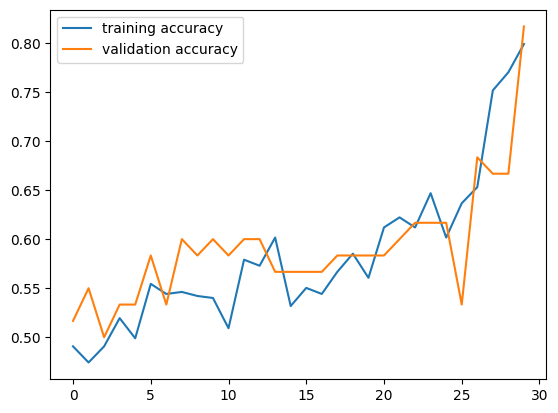

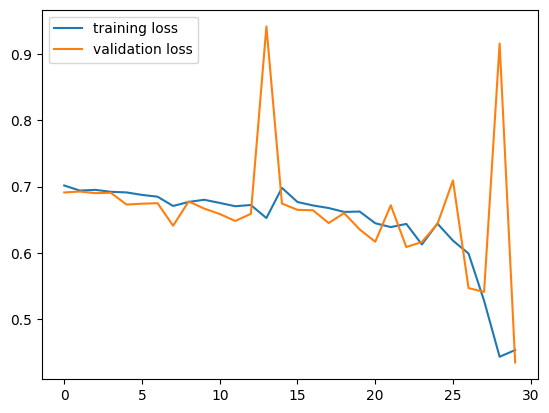

In [30]:
plt.figure()
plt.plot(model.history.history["sparse_categorical_accuracy"], label="training accuracy")
plt.plot(model.history.history["val_sparse_categorical_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [31]:
model.load_weights('best_model.weights.h5')
loss, accuracy = model.evaluate(test_ds)
print("Точность модели CNN: " + str(accuracy))

2024-10-27 01:16:01.044189: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:16:01.049302: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:16:01.090956: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.5905 - sparse_categorical_accuracy: 0.7163
Точность модели CNN: 0.761904776096344


2024-10-27 01:18:27.221681: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:18:27.221781: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:18:27.262060: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:18:27.429685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:18:27.429842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:18:27.470537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Предсказанный ответ: normal
Правильный ответ: normal


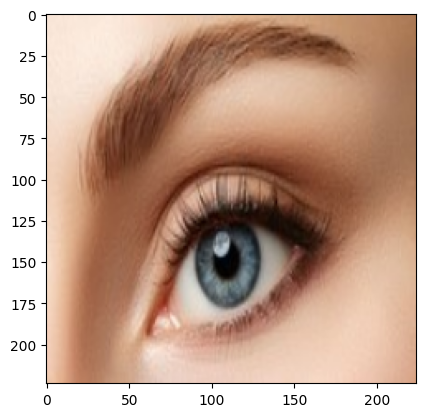

In [36]:
for image_batch, label_batch in test_ds.shuffle(buffer_size=len(list(test_ds))).take(1):
    # Выбираем случайный индекс изображения из мини-пакета
    random_index = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(image_batch)[0], dtype=tf.int32)
    # Извлекаем случайное изображение и метку
    image = image_batch[random_index]
    label = label_batch[random_index]
    predictions = model.predict(tf.expand_dims(image, axis=0))
    # Get the predicted class label
    predicted_class_index = tf.argmax(predictions, axis=-1)
    predicted_class_label = test_ds.class_names[predicted_class_index[0]]
    # Print the predicted class label and true label
    print("Предсказанный ответ:", predicted_class_label)
    print("Правильный ответ:", test_ds.class_names[label])
    plt.imshow(image.numpy().astype("uint8"))

In [37]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
print("Classification Report for Our Convolutional Neural Network")
print(classification_report(true_labels, predicted_labels))

2024-10-27 01:19:56.652410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:19:56.652476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:19:56.692217: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Classification Report for Our Convolutional Neural Network
              precision    recall  f1-score   support

           0       0.86      0.61      0.72        31
           1       0.71      0.91      0.79        32

    accuracy                           0.76        63
   macro avg       0.79      0.76      0.76        63
weighted avg       0.78      0.76      0.76        63



2024-10-27 01:19:57.086678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:19:57.086756: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-10-27 01:19:57.124818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
